In [22]:
import os
import cv2
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [23]:
# Définir le répertoire de sortie
output_dir = '../ndvi/ndvi_cropped_images_straightened'
os.makedirs(output_dir, exist_ok=True)

In [24]:
def load_bands(red_band_path, nir_band_path):
    # Charger les bandes avec rasterio
    with rasterio.open(red_band_path) as red_src:
        red = red_src.read(1).astype('float64')
        red_meta = red_src.meta
    
    with rasterio.open(nir_band_path) as nir_src:
        nir = nir_src.read(1).astype('float64')
    
    # S'assurer que les deux tableaux ont la même forme en les découpant
    min_rows = min(red.shape[0], nir.shape[0])
    red = red[:min_rows, :]
    nir = nir[:min_rows, :]
    
    return red, nir, red_meta

In [25]:
def calculate_ndvi(red, nir):
    # Calcul du NDVI
    ndvi = np.where((nir + red) == 0., 0, (nir - red) / (nir + red))
    return ndvi

In [26]:
def order_points(pts):
    """ Trie les points dans l'ordre: haut-gauche, haut-droit, bas-droit, bas-gauche """
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Somme minimale -> Haut-gauche
    rect[2] = pts[np.argmax(s)]  # Somme maximale -> Bas-droit
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Différence minimale -> Haut-droit
    rect[3] = pts[np.argmax(diff)]  # Différence maximale -> Bas-gauche
    
    return rect

In [27]:
def detect_and_straighten(image, image_name, meta_data, band_name):
    # Normalisation pour OpenCV
    norm_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # Détection des contours avec OpenCV
    _, thresholded = cv2.threshold(norm_image, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Trouver le plus grand contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Détecter les coins de l'image utile
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    if len(approx) >= 4:  # S'assurer qu'il y a au moins 4 coins détectés
        # Sélectionner les 4 coins les plus externes
        pts = approx.reshape(-1, 2)
        rect = order_points(pts)
        
        # Définir les dimensions du nouveau rectangle
        (tl, tr, br, bl) = rect
        widthA = np.linalg.norm(br - bl)
        widthB = np.linalg.norm(tr - tl)
        maxWidth = max(int(widthA), int(widthB))
        
        heightA = np.linalg.norm(tr - br)
        heightB = np.linalg.norm(tl - bl)
        maxHeight = max(int(heightA), int(heightB))
        
        # Points de destination pour obtenir un rectangle parfait
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]
        ], dtype="float32")
        
        # Calcul de la transformation de perspective
        M = cv2.getPerspectiveTransform(rect, dst)
        straightened_image = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        
        return straightened_image
    else:
        print("Les coins n'ont pas été correctement détectés.")
        return image

In [28]:
def crop_to_same_size(image1, image2):
    """ Recadre les deux images à la même taille """
    min_rows = min(image1.shape[0], image2.shape[0])
    min_cols = min(image1.shape[1], image2.shape[1])
    
    image1_cropped = image1[:min_rows, :min_cols]
    image2_cropped = image2[:min_rows, :min_cols]
    
    return image1_cropped, image2_cropped


--- Redressement de l'image B3 (Rouge) ---

--- Redressement de l'image B4 (NIR) ---

--- Recadrage pour alignement parfait ---


C:\Users\billo\AppData\Local\Temp\ipykernel_23404\1562294923.py:3: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) == 0., 0, (nir - red) / (nir + red))


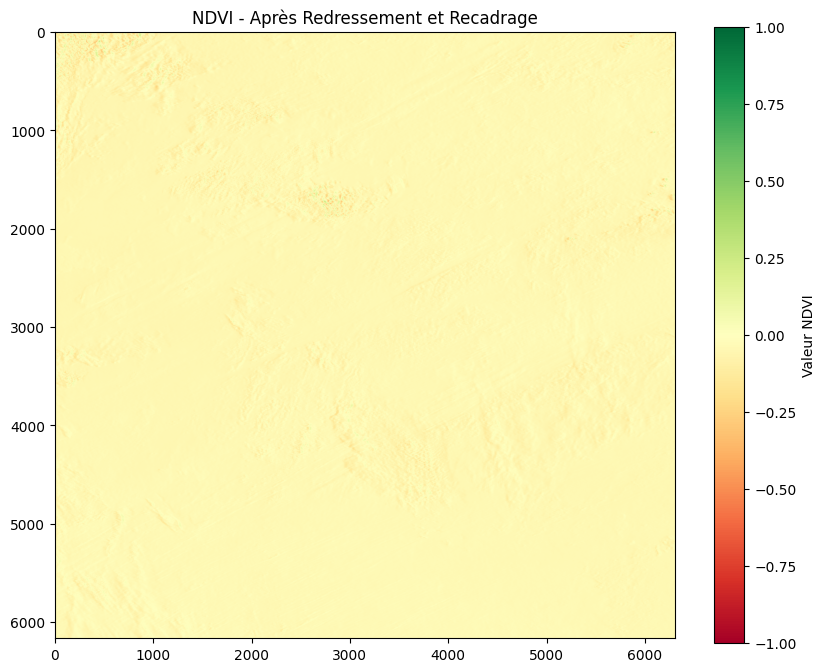

Image NDVI redressée et recadrée sauvegardée dans : ../ndvi/ndvi_cropped_images_straightened\ndvi_straightened.tif


In [29]:
if __name__ == "__main__":
    red_band_path = '../data/cropped_images/LT05_L1TP_196047_19950627_20200912_02_T1_B3_cropped.TIF'
    nir_band_path = '../data/cropped_images/LT05_L1TP_196047_19950627_20200912_02_T1_B4_cropped.TIF'
    
    # Charger les bandes
    red, nir, meta_data = load_bands(red_band_path, nir_band_path)
    
    # Redressement de B3 (Rouge)
    print("\n--- Redressement de l'image B3 (Rouge) ---")
    red_straightened = detect_and_straighten(red, red_band_path, meta_data, 'B3_Rouge')
    
    # Redressement de B4 (NIR)
    print("\n--- Redressement de l'image B4 (NIR) ---")
    nir_straightened = detect_and_straighten(nir, nir_band_path, meta_data, 'B4_NIR')
    
    # Recadrage pour aligner les dimensions
    print("\n--- Recadrage pour alignement parfait ---")
    red_cropped, nir_cropped = crop_to_same_size(red_straightened, nir_straightened)
    
    # Calcul du NDVI avec les images recadrées et alignées
    ndvi = calculate_ndvi(red_cropped, nir_cropped)
    
    # Visualisation du NDVI
    plt.figure(figsize=(10, 8))
    plt.title('NDVI - Après Redressement et Recadrage')
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.colorbar(label='Valeur NDVI')
    plt.show()
    
    # Sauvegarde du NDVI en GeoTIFF
    output_ndvi_path = os.path.join(output_dir, 'ndvi_straightened.tif')
    with rasterio.open(
        output_ndvi_path, 'w',
        driver='GTiff',
        height=ndvi.shape[0],
        width=ndvi.shape[1],
        count=1,
        dtype='float32',
        crs=meta_data['crs'],
        transform=meta_data['transform']
    ) as dst:
        dst.write(ndvi, 1)
    
    print(f'Image NDVI redressée et recadrée sauvegardée dans : {output_ndvi_path}')